This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



# ***Uber rides area affected by weather, in additional to trends and seasonality. ***

In [0]:
# -----------------------------------------------------------
# HW 3 
# Author : P. Mondal
# Date : Mar 4, 2020
# Topic : Getting familiarized with Facebook Prophet Package
# -----------------------------------------------------------

In [420]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


![alt text](https://)

 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [421]:
!pip install fbprophet


In [0]:
import fbprophet

In [0]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [0]:
# Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014.
# data = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv")

In [0]:
#data.shape
'''
pre_str = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-'
mon = 'apr'
post_str = '14.csv'
pre_str+mon+post_str
data = pd.read_csv(pre_str+mon+post_str)
data.shape
'''

(564516, 4)

# Reading file.csv from repository 

In [424]:
pre_str = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-'
post_str = '14.csv'

a = []

df1 = pd.DataFrame()

# Concatenate data of each months

for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    xx = pd.read_csv(pre_str+mon+post_str)
    print(xx.shape)
    print(pre_str+mon+post_str)
    df1 = pd.concat([df1, xx])
    #print(yy.shape)
print('Total data size', df1.shape)
a = df1.values.tolist()


(564516, 4)
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
(652435, 4)
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
(663844, 4)
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
(796121, 4)
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
(829275, 4)
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
(1028136, 4)
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv
Total data size (4534327, 4)


In [0]:
np.array(a).shape

(4534327, 4)

In [0]:
564516 + 652435 + 663844

1880795

In [0]:
#type(a)
type(df1)

pandas.core.frame.DataFrame

In [425]:
# Created a single dataframe uberrides or df1 from input file.csv of months from April to September
uberrides = df1
print(type(uberrides))
print(uberrides.shape)

<class 'pandas.core.frame.DataFrame'>
(4534327, 4)


# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [426]:
print(df1)

                  Date/Time      Lat      Lon    Base
0          4/1/2014 0:11:00  40.7690 -73.9549  B02512
1          4/1/2014 0:17:00  40.7267 -74.0345  B02512
2          4/1/2014 0:21:00  40.7316 -73.9873  B02512
3          4/1/2014 0:28:00  40.7588 -73.9776  B02512
4          4/1/2014 0:33:00  40.7594 -73.9722  B02512
...                     ...      ...      ...     ...
1028131  9/30/2014 22:57:00  40.7668 -73.9845  B02764
1028132  9/30/2014 22:57:00  40.6911 -74.1773  B02764
1028133  9/30/2014 22:58:00  40.8519 -73.9319  B02764
1028134  9/30/2014 22:58:00  40.7081 -74.0066  B02764
1028135  9/30/2014 22:58:00  40.7140 -73.9496  B02764

[4534327 rows x 4 columns]


In [427]:
df1.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [428]:
tt = df1.Lat
print(tt)
print(df1['Date/Time'])

0          40.7690
1          40.7267
2          40.7316
3          40.7588
4          40.7594
            ...   
1028131    40.7668
1028132    40.6911
1028133    40.8519
1028134    40.7081
1028135    40.7140
Name: Lat, Length: 4534327, dtype: float64
0            4/1/2014 0:11:00
1            4/1/2014 0:17:00
2            4/1/2014 0:21:00
3            4/1/2014 0:28:00
4            4/1/2014 0:33:00
                  ...        
1028131    9/30/2014 22:57:00
1028132    9/30/2014 22:57:00
1028133    9/30/2014 22:58:00
1028134    9/30/2014 22:58:00
1028135    9/30/2014 22:58:00
Name: Date/Time, Length: 4534327, dtype: object


In [429]:
pd.to_datetime(df1['Date/Time'])

0         2014-04-01 00:11:00
1         2014-04-01 00:17:00
2         2014-04-01 00:21:00
3         2014-04-01 00:28:00
4         2014-04-01 00:33:00
                  ...        
1028131   2014-09-30 22:57:00
1028132   2014-09-30 22:57:00
1028133   2014-09-30 22:58:00
1028134   2014-09-30 22:58:00
1028135   2014-09-30 22:58:00
Name: Date/Time, Length: 4534327, dtype: datetime64[ns]

In [0]:
# Converting to datetime with column name "times"
uberrides["time"] = pd.to_datetime(uberrides['Date/Time'])

In [0]:
#pd.to_datetime??

In [431]:
pd.to_datetime

<function pandas.core.tools.datetimes.to_datetime>

In [432]:
uberrides.iloc[0]["time"].date

<function Timestamp.date>

In [433]:
# you can use groupby with the "date" attribute, which means grouping by day, 
#and use the method count of groupby to count the number of rides in each group.
# Groupin by daye and counting
uberbyday = uberrides.groupby(uberrides["time"].dt.date).agg(['count'])
print(uberbyday)

           Date/Time    Lat    Lon   Base   time
               count  count  count  count  count
time                                            
2014-04-01     14546  14546  14546  14546  14546
2014-04-02     17474  17474  17474  17474  17474
2014-04-03     20701  20701  20701  20701  20701
2014-04-04     26714  26714  26714  26714  26714
2014-04-05     19521  19521  19521  19521  19521
...              ...    ...    ...    ...    ...
2014-09-26     37504  37504  37504  37504  37504
2014-09-27     39468  39468  39468  39468  39468
2014-09-28     29656  29656  29656  29656  29656
2014-09-29     29201  29201  29201  29201  29201
2014-09-30     33431  33431  33431  33431  33431

[183 rows x 5 columns]


In [0]:
uberbyday.Lat.count

<bound method DataFrame.count of             count
time             
2014-04-01  14546
2014-04-02  17474
2014-04-03  20701
2014-04-04  26714
2014-04-05  19521
...           ...
2014-09-26  37504
2014-09-27  39468
2014-09-28  29656
2014-09-29  29201
2014-09-30  33431

[183 rows x 1 columns]>

In [0]:
uberbyday.time

,count
time,
2014-04-01,14546
2014-04-02,17474
2014-04-03,20701
2014-04-04,26714
2014-04-05,19521
...,...
2014-09-26,37504
2014-09-27,39468
2014-09-28,29656


**Finally, rename the dataframe so that the number of rides is column y and the dates are column ds - this is required by the prophet package that you will use for the enalysis.**

In [434]:
uberbyday.rename(columns={'Lat' : 'y', }, inplace = True)
uberbyday['ds'] = uberbyday.index
#rankings_pd.rename(columns = {'test':'TEST'}, inplace = True) 
print(uberbyday)

           Date/Time      y    Lon   Base   time          ds
               count  count  count  count  count            
time                                                        
2014-04-01     14546  14546  14546  14546  14546  2014-04-01
2014-04-02     17474  17474  17474  17474  17474  2014-04-02
2014-04-03     20701  20701  20701  20701  20701  2014-04-03
2014-04-04     26714  26714  26714  26714  26714  2014-04-04
2014-04-05     19521  19521  19521  19521  19521  2014-04-05
...              ...    ...    ...    ...    ...         ...
2014-09-26     37504  37504  37504  37504  37504  2014-09-26
2014-09-27     39468  39468  39468  39468  39468  2014-09-27
2014-09-28     29656  29656  29656  29656  29656  2014-09-28
2014-09-29     29201  29201  29201  29201  29201  2014-09-29
2014-09-30     33431  33431  33431  33431  33431  2014-09-30

[183 rows x 6 columns]


In [0]:
#uberbyday['y'] = uberbyday.index

Text(0, 0.5, 'Number of rides')

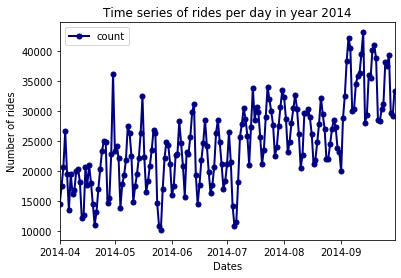

In [436]:
#...
ax = uberbyday.plot(x="ds", y="y",lw=2, colormap='jet', marker='.', markersize=10, title="Time series of rides per day in year 2014")
ax.set_xlabel("Dates")
ax.set_ylabel("Number of rides")
# Note "Dates" are actually "ds" and "count" is actually "y" i.e. number of rides 

Fig1. The figure shows time series of uber rides per day from april to September, 2014. It shows an increased trend. 

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

In [437]:
print(uberbyday['y'])
#df['y'] = np.log(df['y'])
#mean1 = np.mean(uberbyday['y'])
#print(uberbyday['y'].mean(axis = 1, skipna = True))
# STD and mean over the column axis. 
#uberbyday['mean'] = uberbyday.mean(axis = 1, skipna = True) 
#uberbyday['std'] = uberbyday.std(axis = 1, skipna = True) 

# Scaling the date by subtracting mean from it and dividing by standard dediation
uberbyday['y'] = (uberbyday['y'] - np.mean(uberbyday['y']))/np.std(uberbyday['y']) 

            count
time             
2014-04-01  14546
2014-04-02  17474
2014-04-03  20701
2014-04-04  26714
2014-04-05  19521
...           ...
2014-09-26  37504
2014-09-27  39468
2014-09-28  29656
2014-09-29  29201
2014-09-30  33431

[183 rows x 1 columns]


In [0]:
uberbyday['y']

,count
time,
2014-04-01,-1.453505
2014-04-02,-1.037558
2014-04-03,-0.579136
2014-04-04,0.275062
2014-04-05,-0.746764
...,...
2014-09-26,1.807871
2014-09-27,2.086874
2014-09-28,0.692997


In [0]:
#print(uberbyday['std'])

Text(0, 0.5, 'Rides per day')

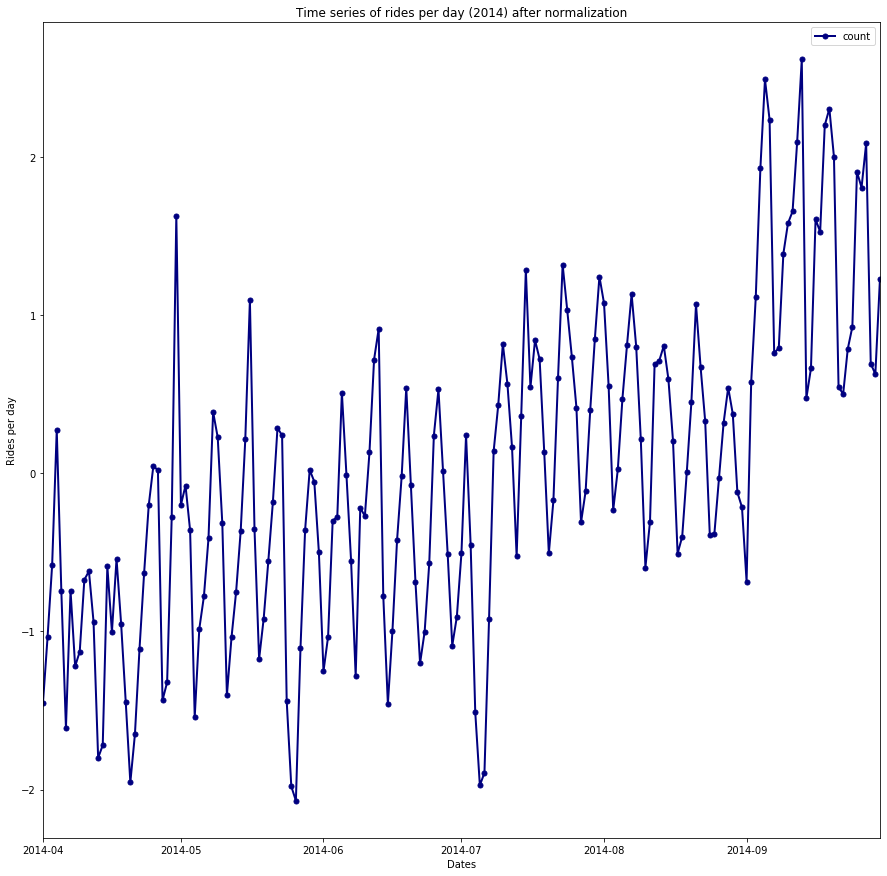

In [444]:
#Subtract the mean and divide by the standard deviation the y column. 
#...
ax2 = uberbyday.plot(x="ds", y="y", lw=2, colormap='jet', marker='.', 
                     markersize=10, title="Time series of rides per day (2014) after normalization", figsize=(15,15))
ax2.set_xlabel("Dates")
ax2.set_ylabel("Rides per day")

fig2 : The figure shows uber rides per day same as figure one but rescaled value since the y-value now is mean subtracted from y-value and divided by standard diviation. The reason for rescaling is it will be advantageous for regression calculation.



# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [0]:
df_test = pd.DataFrame()

In [446]:
# Define model and fit the date
simplem = Prophet()
df_test['ds'] = uberbyday['ds']
df_test['y'] = uberbyday['y']
simplem.fit(df_test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [447]:
print(df_test)


                    ds         y
time                            
2014-04-01  2014-04-01 -1.453505
2014-04-02  2014-04-02 -1.037558
2014-04-03  2014-04-03 -0.579136
2014-04-04  2014-04-04  0.275062
2014-04-05  2014-04-05 -0.746764
...                ...       ...
2014-09-26  2014-09-26  1.807871
2014-09-27  2014-09-27  2.086874
2014-09-28  2014-09-28  0.692997
2014-09-29  2014-09-29  0.628361
2014-09-30  2014-09-30  1.229268

[183 rows x 2 columns]


In [0]:
future = simplem.make_future_dataframe(periods=365)
future.tail()

,ds
543,2015-09-26
544,2015-09-27
545,2015-09-28
546,2015-09-29
547,2015-09-30


In [448]:
forecast = simplem.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
543,2015-09-26,5.927200,5.214944,6.554872
544,2015-09-27,5.073948,4.434462,5.772049
545,2015-09-28,5.354602,4.693443,6.033156
546,2015-09-29,5.935159,5.298588,6.570344
547,2015-09-30,6.294616,5.616246,6.909878


Text(0.5, 1, 'Forcast by Prophet (blue) after fitting the training data (red) when only trend and seasonality are considered')

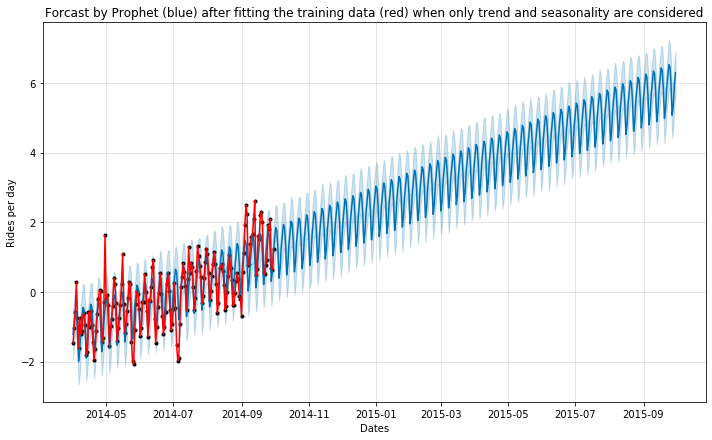

In [453]:

fig3 = simplem.plot(forecast)
pl.plot(uberbyday.y, 'r-')
pl.xlabel('Dates')
pl.ylabel('Rides per day')
pl.title('Forcast by Prophet (blue) after fitting the training data (red) when only trend and seasonality are considered')



Fig4 : The figure shows forcast by prophet (blue) when fitted to the data (red)considering only data trend and seasonality.  



# Plot of data trend of uber ride data : Top figure shows the trend over years and bottom shows weekly behavior.

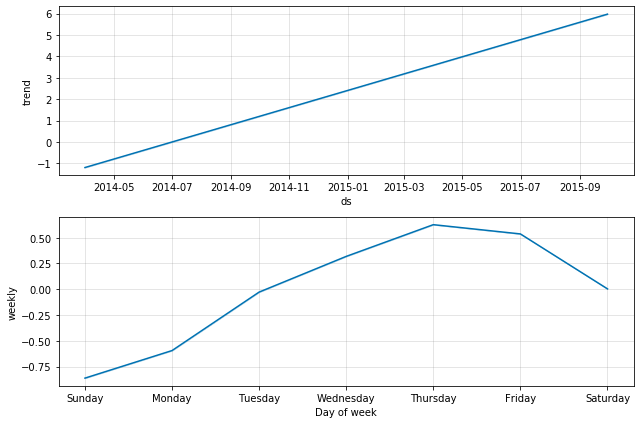

In [0]:
fig2 = simplem.plot_components(forecast)
#fig2.xlabel("Dates")
#ax.set_ylabel("Count")

Fig 5: The top figure shows data trend over the considered months i.e. from April to Spetember. We do see an increased trend in the data over months. However the bottom figure shows weekly behavior of the data which shows a peak on Thursday and minimum value on Sunday. The bottom figure therefore implies that uber rides are not profitale as much on SUnday as is on Thursday of the week. 

In [0]:
simplem.plot_components??


# DATA ANALYSIS: model validation

---


 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [0]:
diagnostics.cross_validation?
from fbprophet.diagnostics import cross_validation


In [455]:
def rchi2(y, ytrue, num_obs):
    sig = 1 # Standard deviation
    return sum((y - ytrue)**2/sig**2)/num_obs
cvresult_simplem = cross_validation(simplem, initial='30 days',period = '30 days', horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-03 00:00:00 and 2014-08-31 00:00:00


In [0]:
print(cvresult_simplem)

            ds      yhat  yhat_lower  yhat_upper         y     cutoff
0   2014-05-04 -1.260491   -1.902828   -0.617442 -1.542718 2014-05-03
1   2014-05-05 -0.917607   -1.522359   -0.291965 -0.982865 2014-05-03
2   2014-05-06 -0.396521   -1.067424    0.175578 -0.778159 2014-05-03
3   2014-05-07  0.102784   -0.549465    0.728601 -0.410086 2014-05-03
4   2014-05-08  0.096953   -0.564281    0.718694  0.388566 2014-05-03
..         ...       ...         ...         ...       ...        ...
145 2014-09-26  1.162421    0.584281    1.774380  1.807871 2014-08-31
146 2014-09-27  0.541982   -0.089422    1.161802  2.086874 2014-08-31
147 2014-09-28 -0.166410   -0.750516    0.452698  0.692997 2014-08-31
148 2014-09-29  0.185724   -0.413596    0.757669  0.628361 2014-08-31
149 2014-09-30  0.712232    0.096246    1.258374  1.229268 2014-08-31

[150 rows x 6 columns]


In [0]:
len(cvresult_simplem['y'])

150

In [456]:
# chi2 fit value
rchi2(cvresult_simplem['y'], cvresult_simplem['yhat'], len(cvresult_simplem['y']))

0.44886413690614657

** 
Not a good fit as reduced $\chi^2$ value is much less than 1. 
**







# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [464]:
!pip install wwo_hist

In [0]:
from wwo_hist import retrieve_hist_data

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


**Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests). an install and import the wwo_hist package

Save your key in a separate file and read it in. For example, you can create a file my_apis.csv in the same folder where you are working and the content of the file can be wwo,XXXXXXXXXXXXXXXXX

This should download a New+york,ny.csv file which you can then read in.**

In [0]:
!rm my_apis*.csv


In [0]:
# Getting API key
!echo "wwo,36a9510af3be4cfeae7221138200403" >> my_apis.csv

In [0]:
!cat my_apis.csv

wwo,36a9510af3be4cfeae7221138200403


In [457]:
# Downloading exogenous variable i.e. weather data
frequency = 24 #frequency in hours
start_date = '2014-04-01'
end_date = '2014-09-30'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:01.033964
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:02.101154
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:03.125615
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:04.445176
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:05.683065
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:06.527876
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:07.123131


export New+york,ny completed!




In [0]:
%ls *.csv

my_apis.csv  New+york,ny.csv


In [458]:
# Reading file.csv
weather = pd.read_csv("New+york,ny.csv")
print(weather)

      date_time  maxtempC  mintempC  ...  visibility  winddirDegree  windspeedKmph
0    2014-04-01        12         2  ...          10            269             11
1    2014-04-02        12         4  ...           9            208              6
2    2014-04-03        13         6  ...          10            209              7
3    2014-04-04         6         5  ...           9             96             15
4    2014-04-05        10         3  ...           9            259             19
..          ...       ...       ...  ...         ...            ...            ...
208  2014-09-26        23        13  ...          10             58             11
209  2014-09-27        25        15  ...          10            161              7
210  2014-09-28        26        15  ...          10            206              6
211  2014-09-29        24        17  ...          10            248              6
212  2014-09-30        21        17  ...           7            146              8

[21

In [0]:

# Rename column date_time to time 
weather.rename(columns={'date_time' : 'time', }, inplace = True)


In [0]:
# Setting index to datetime. Not sure what is the advantage of this.
weather.set_index(pd.to_datetime(weather.time), inplace=True)

In [467]:
print((weather))

                  time  maxtempC  ...  winddirDegree  windspeedKmph
time                              ...                              
2014-04-01  2014-04-01        12  ...            269             11
2014-04-02  2014-04-02        12  ...            208              6
2014-04-03  2014-04-03        13  ...            209              7
2014-04-04  2014-04-04         6  ...             96             15
2014-04-05  2014-04-05        10  ...            259             19
...                ...       ...  ...            ...            ...
2014-09-26  2014-09-26        23  ...             58             11
2014-09-27  2014-09-27        25  ...            161              7
2014-09-28  2014-09-28        26  ...            206              6
2014-09-29  2014-09-29        24  ...            248              6
2014-09-30  2014-09-30        21  ...            146              8

[213 rows x 25 columns]


In [468]:
type(weather)

pandas.core.frame.DataFrame

In [469]:
weather.columns

Index(['time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex',
       'uvIndex.1', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [0]:
# Creating a new dataframe with columns "tempC" and "precipMM"
Weather_2 = pd.DataFrame()

In [0]:
Weather_2['tempC'] = weather['tempC']

In [472]:
Weather_2['precipMM'] = weather['precipMM']
print(Weather_2)

            tempC  precipMM
time                       
2014-04-01     12       0.0
2014-04-02     12       0.2
2014-04-03     13       0.0
2014-04-04      6       4.5
2014-04-05     10       0.1
...           ...       ...
2014-09-26     23       0.0
2014-09-27     25       0.0
2014-09-28     26       0.0
2014-09-29     24       0.1
2014-09-30     21       0.8

[213 rows x 2 columns]


In [473]:
df_test

,ds,y
time,,
2014-04-01,2014-04-01,-1.453505
2014-04-02,2014-04-02,-1.037558
2014-04-03,2014-04-03,-0.579136
2014-04-04,2014-04-04,0.275062
2014-04-05,2014-04-05,-0.746764
...,...,...
2014-09-26,2014-09-26,1.807871
2014-09-27,2014-09-27,2.086874
2014-09-28,2014-09-28,0.692997


In [474]:
# Adding another column "ds" to avoid merging error which requires atleast 
# one common column between two dataframes we want to merge.
Weather_2['ds'] = df_test['ds']
Weather_2

,tempC,precipMM,ds
time,,,
2014-04-01,12,0.0,2014-04-01
2014-04-02,12,0.2,2014-04-02
2014-04-03,13,0.0,2014-04-03
2014-04-04,6,4.5,2014-04-04
2014-04-05,10,0.1,2014-04-05
...,...,...,...
2014-09-26,23,0.0,2014-09-26
2014-09-27,25,0.0,2014-09-27
2014-09-28,26,0.0,2014-09-28


In [0]:
uberweather = pd.merge( df_test, Weather_2)

In [476]:
uberweather

,ds,y,tempC,precipMM
0,2014-04-01,-1.453505,12,0.0
1,2014-04-02,-1.037558,12,0.2
2,2014-04-03,-0.579136,13,0.0
3,2014-04-04,0.275062,6,4.5
4,2014-04-05,-0.746764,10,0.1
...,...,...,...,...
208,2014-09-28,0.692997,26,0.0
209,2014-09-29,0.628361,24,0.1
210,2014-09-29,0.628361,24,0.1
211,2014-09-30,1.229268,21,0.8


# Please read this 

In [0]:
# One may uncomment this line to get indexing by timestamp as datetime. Here 
# I will keep it commented since running the command below will create indexing 
# with "ds" and there will be a "ds" column which will create conde confusion 
# later.

#uberweather.set_index(pd.to_datetime(uberweather.ds), inplace=True)

In [0]:
uberweather

,ds,y,tempC,precipMM
0,2014-04-01,-1.453505,12,0.0
1,2014-04-02,-1.037558,12,0.2
2,2014-04-03,-0.579136,13,0.0
3,2014-04-04,0.275062,6,4.5
4,2014-04-05,-0.746764,10,0.1
...,...,...,...,...
208,2014-09-28,0.692997,26,0.0
209,2014-09-29,0.628361,24,0.1
210,2014-09-29,0.628361,24,0.1
211,2014-09-30,1.229268,21,0.8


In [0]:
#weather

In [0]:
#result = pd.merge(Weather_2, weather)

In [0]:
#print(result)

In [0]:
pd.merge??

In [0]:
#leave
uberweather

,y,ds,tempC,precipMM
2014-04-01,-1.521465,2014-04-01,-1.959822,-0.484962
2014-04-02,-1.136392,2014-04-02,-1.959822,-0.430609
2014-04-03,-0.711997,2014-04-03,-1.766830,-0.484962
2014-04-04,0.078797,2014-04-04,-3.117776,0.737969
2014-04-05,-0.867183,2014-04-05,-2.345807,-0.457786
...,...,...,...,...
2014-09-28,0.465711,2014-09-28,0.742069,-0.484962
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-30,0.962176,2014-09-30,-0.222892,-0.267552


Text(0, 0.5, 'precipMM')

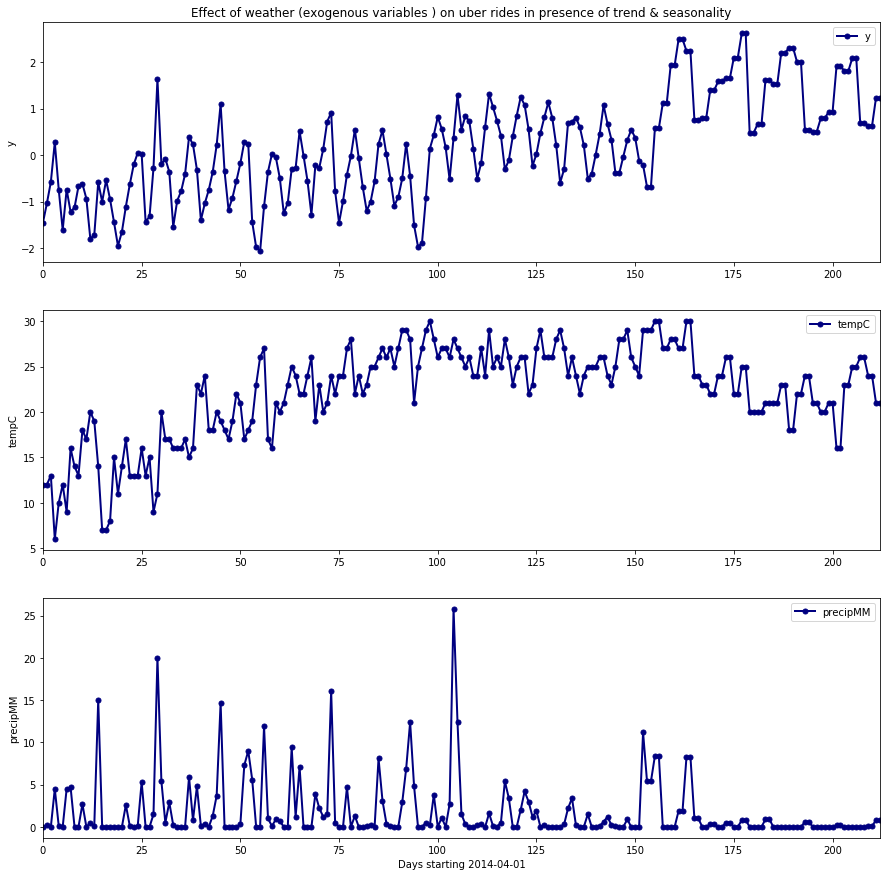

In [479]:
fig, ax = pl.subplots(3, figsize = (15,15))
uberweather.plot(y="y", ax=ax[0], lw=2, colormap='jet', marker='.', 
                     markersize=10, title="Effect of weather (exogenous variables ) on uber rides in presence of trend & seasonality")
uberweather.plot(y="tempC", ax=ax[1], lw=2, colormap='jet', marker='.', 
                     markersize=10)
uberweather.plot(y="precipMM", ax=ax[2], lw=2, colormap='jet', marker='.', 
                     markersize=10)
ax[2].set_xlabel('Days starting 2014-04-01')
ax[0].set_ylabel('y')
ax[1].set_ylabel('tempC')
ax[2].set_ylabel('precipMM')


Fig 6 : Here we see the effect of exogenous valiables arising due to weather that's affecting uber rides per day. Top most panel shows the previous data and middle panel shows temperature variation during those days and bottom panel shows variation of precipMM. Not sure about bottom two panels.

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [481]:
# Prophet model with tempC and precipMM under consideration
regrm = Prophet()
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')

In [482]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


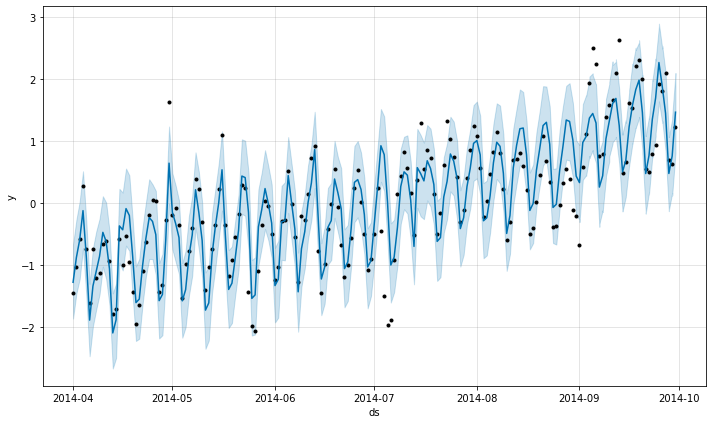

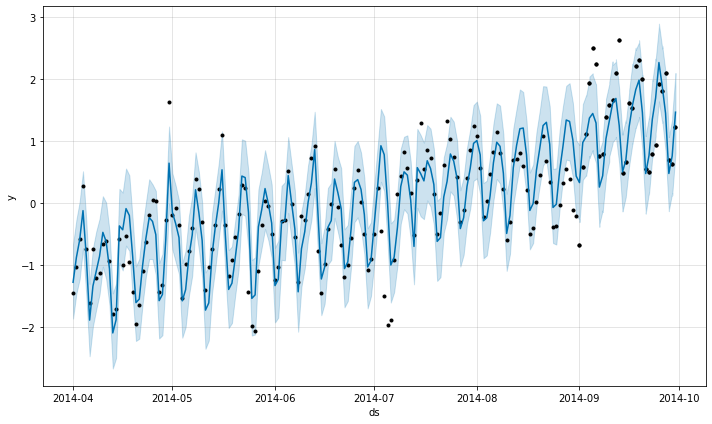

In [483]:
nowcast = regrm.predict(uberweather)
axs = simplem.plot(nowcast)
regrm.plot(nowcast);



Fig 7 : The figures above shows how well the model predicted by prophet is when we consider tempC and precipMM as exogenous variables along with trend and seasonality. 




# Cross Validation 

In [484]:
cvresult_simplem2 = cross_validation(regrm, initial='30 days',period = '30 days', horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-03 00:00:00 and 2014-08-31 00:00:00


In [485]:
cvresult_simplem2

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-04,-1.442425,-1.796100,-1.080409,-1.542718,2014-05-03
1,2014-05-05,-1.208058,-1.553636,-0.845192,-0.982865,2014-05-03
2,2014-05-06,-1.080267,-1.435409,-0.718393,-0.778159,2014-05-03
3,2014-05-07,-0.636528,-0.986854,-0.287296,-0.410086,2014-05-03
4,2014-05-08,0.340495,-0.008432,0.703720,0.388566,2014-05-03
...,...,...,...,...,...,...
175,2014-09-28,-0.002016,-0.524241,0.559679,0.692997,2014-08-31
176,2014-09-29,0.384444,-0.187817,0.850280,0.628361,2014-08-31
177,2014-09-29,0.384444,-0.162215,0.949531,0.628361,2014-08-31
178,2014-09-30,0.956146,0.406529,1.493078,1.229268,2014-08-31


In [486]:
rchi2(cvresult_simplem2['y'], cvresult_simplem2['yhat'], len(cvresult_simplem2['y']))

0.4234397128992029

In [0]:
# Two models ????

# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [487]:
regholm = Prophet()
regholm.add_country_holidays(country_name="US")

In [488]:
# Fit the model
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


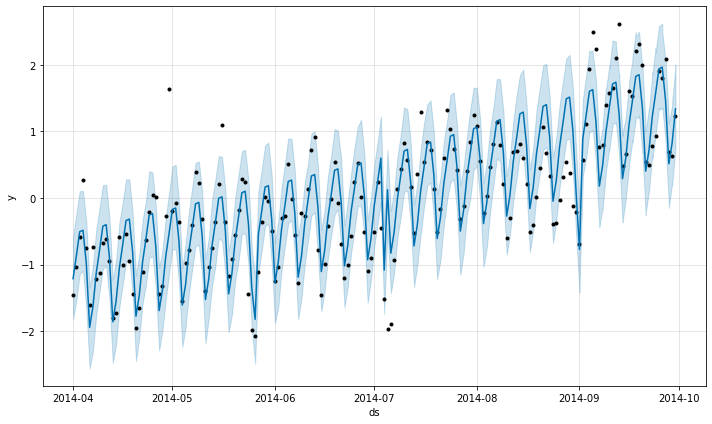

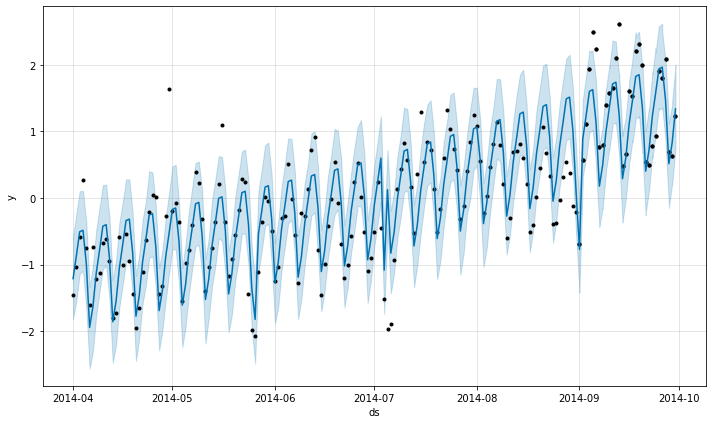

In [489]:
# Predict & plot
nowcast_hol = regholm.predict(uberweather)
simplem.plot(nowcast_hol)
regholm.plot(nowcast_hol);



Fig 8 : The figures above shows how well the model predicted by prophet is when we consider tempC and precipMM and holidays as exogenous variables along with trend and seasonality. 







Caption : **Here I tried to check the effect of holidays on uberride time series** 



In [0]:
#crossvalidate, calculate and compare the reduced chi2
cvresult_simplem_hol = cross_validation(regholm, initial='30 days',period = '30 days', horizon='30 days')
#rchi2...

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-03 00:00:00 and 2014-08-31 00:00:00


In [0]:
rchi2(cvresult_simplem_hol['y'], cvresult_simplem_hol['yhat'], len(cvresult_simplem_hol['y']))

0.4862318408335652

# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [0]:
regmcmc = Prophet(mcmc_samples=5000)
#...

In [0]:
# Fit the model
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


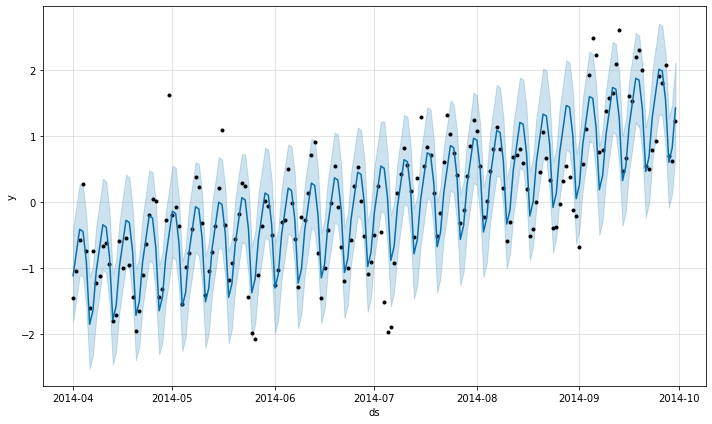

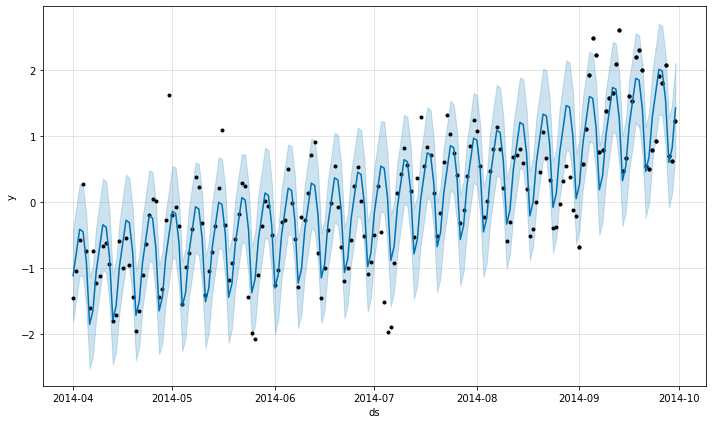

In [0]:
# Predict & plot
nowcast_mcmc = regmcmc.predict(uberweather)
simplem.plot(nowcast_mcmc)
regmcmc.plot(nowcast_mcmc);



Fig 9 : The figures above shows how well the model predicted by prophet is when we consider tempC and precipMM and holidays as exogenous variables along with trend and seasonality. Only difference is MCMC is used for optimization. 




In [0]:
#crossvalidate, calculate and compare the reduced chi2
cvresult_simplem_mcmc = cross_validation(regmcmc, initial='30 days',period = '30 days', horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-03 00:00:00 and 2014-08-31 00:00:00


In [0]:
rchi2(cvresult_simplem_mcmc['y'], cvresult_simplem_mcmc['yhat'], len(cvresult_simplem_mcmc['y']))

0.5746544191532007

# I would conclude that Model 4 gives a better fitted model compared to other three with reduced $\chi^2$ as 0.57 where as model 1, 2, 3 have reduced $\chi^2$ of 0.4488, 0.4234, 0.4862. 

# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm

# End of Homework 3 !